# Training: Hybrid case

## Preparation

We start by specifying some training hyperparameters and importing NumPy and PyTorch.

In [1]:
BATCH_SIZE = 10
EPOCHS = 15
SEED = 42

In [2]:
import torch
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

### Input data

Let's read the data and print some example sentences.

In [3]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../examples/datasets/mc_train_data.txt')
dev_labels, dev_data = read_data('../examples/datasets/mc_dev_data.txt')
test_labels, test_data = read_data('../examples/datasets/mc_test_data.txt')

In [4]:
train_data[:5]

['skillful man prepares sauce .',
 'skillful man bakes dinner .',
 'woman cooks tasty meal .',
 'man prepares meal .',
 'skillful woman debugs program .']

Targets are represented as 2-dimensional arrays:

In [5]:
train_labels[:5]

[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [0.0, 1.0]]

### Creating and parameterising diagrams

In [6]:
from lambeq import BobcatParser

reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


### Simplify diagrams

In [7]:
from lambeq import remove_cups

train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

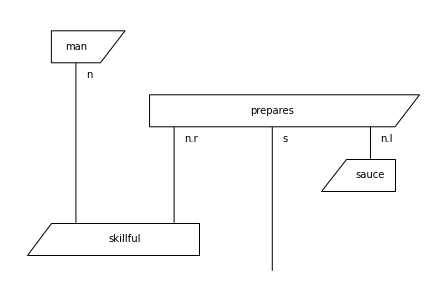

In [8]:
train_diagrams[0].draw()

### Create circuits

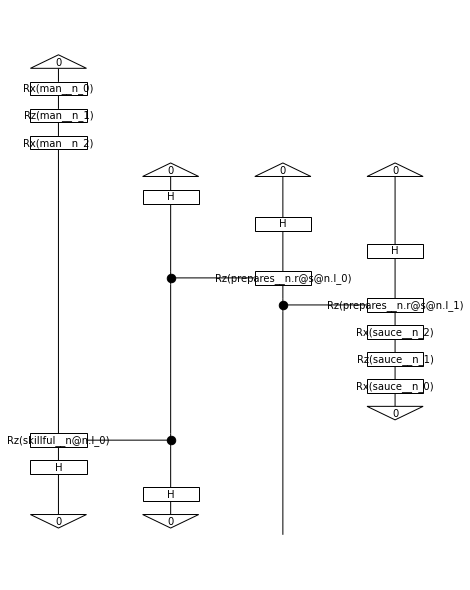

In [9]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(6, 8))

## Training
### Instantiate model

In [10]:
from lambeq import PennyLaneModel

all_circuits = train_circuits + dev_circuits + test_circuits

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit',  # this is the default PennyLane simulator
                  'probabilities': True,
                  'normalize': True}
model = PennyLaneModel.from_diagrams(all_circuits,
                                     backend_config=backend_config)
model.initialise_weights()
model = model.double()

### Running on a real quantum computer

In [ ]:
import pennylane as qml

qml.default_config['qiskit.ibmq.ibmqx_token'] = 'my_API_token'
qml.default_config.save(qml.default_config.path)

In [ ]:
backend_config = {'backend': 'qiskit.ibmq',
                  'device': 'ibmq_manila',
                  'probabilities': True,
                  'normalize': True,
                  'shots': 1000}

q_model = PennyLaneModel.from_diagrams(all_circuits,
                                       backend_config=backend_config)
q_model.initialise_weights()

In [ ]:
qml.default_config['honeywell.global.user_email'] = ('my_Honeywell/Quantinuum_'
                                                     'account_email')
qml.default_config.save(qml.default_config.path)

In [ ]:
backend_config = {'backend': 'honeywell.hqs',
                  'device': 'H1-1E',
                  'probabilities': True,
                  'normalize': True,
                  'shots': 1000}

h_model = PennyLaneModel.from_diagrams(all_circuits,
                                       backend_config=backend_config)
h_model.initialise_weights()

### Create datasets

In [11]:
from lambeq import Dataset

train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels)

### Define loss and evaluation metric

In [12]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.mse_loss(y_hat, y.double())

### Initialise trainer

In [13]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=0.1,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

### Train

In [14]:
trainer.fit(train_dataset, val_dataset)

Epoch 1:   train/loss: 0.2597   valid/loss: 0.2860   train/acc: 0.5429   valid/acc: 0.5000
Epoch 2:   train/loss: 0.1886   valid/loss: 0.0731   train/acc: 0.7714   valid/acc: 0.8667
Epoch 3:   train/loss: 0.0756   valid/loss: 0.0897   train/acc: 0.9429   valid/acc: 0.8667
Epoch 4:   train/loss: 0.0516   valid/loss: 0.0375   train/acc: 0.9714   valid/acc: 1.0000
Epoch 5:   train/loss: 0.0244   valid/loss: 0.0216   train/acc: 0.9857   valid/acc: 1.0000
Epoch 6:   train/loss: 0.0362   valid/loss: 0.0183   train/acc: 0.9571   valid/acc: 0.9667
Epoch 7:   train/loss: 0.0153   valid/loss: 0.0363   train/acc: 0.9857   valid/acc: 0.9667
Epoch 8:   train/loss: 0.0204   valid/loss: 0.0495   train/acc: 0.9857   valid/acc: 0.9333
Epoch 9:   train/loss: 0.0314   valid/loss: 0.0312   train/acc: 0.9714   valid/acc: 0.9667
Epoch 10:  train/loss: 0.0382   valid/loss: 0.0707   train/acc: 0.9429   valid/acc: 0.9333
Epoch 11:  train/loss: 0.0364   valid/loss: 0.1207   train/acc: 0.9571   valid/acc: 0.8333

## Results

Finally, we visualise the results and evaluate the model on the test data.

Final test accuracy: 0.9333333333333333


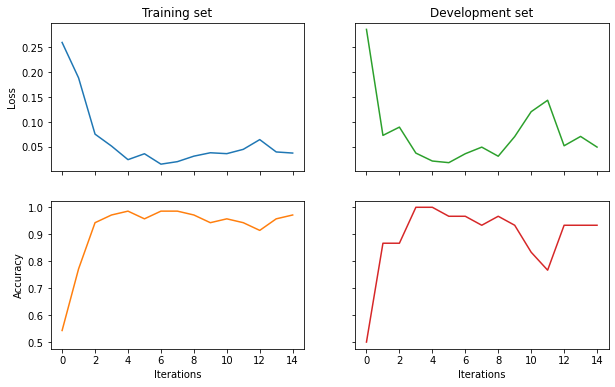

In [15]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer.train_results['acc'], color=next(colours))
ax_tr.plot(trainer.val_costs, color=next(colours))
ax_br.plot(trainer.val_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circuits)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))

## Using standard PyTorch

As we have a small dataset, we can use early stopping to prevent overfitting to the training data. In this case, we evaluate the performance of the model on the validation dataset every 5 epochs, and save a checkpoint if the validation accuracy has improved. If it does not improve for 10 epochs, we end the training, and load the model with the best validation accuracy.

In [16]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) ==
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

Training is the same as standard PyTorch. We initialize an optimizer, pass it the model parameters, and then run a training loop in which we compute the loss, run a backwards pass to compute the gradients, and then take an optimizer step.

In [17]:
model = PennyLaneModel.from_diagrams(all_circuits)
model.initialise_weights()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_dataset:
        optimizer.zero_grad()
        probs = model(circuits)
        loss = torch.nn.functional.mse_loss(probs,
                                            torch.tensor(labels).double())
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    if i % 5 == 0:
        dev_acc = accuracy(dev_circuits, dev_labels)
        
        print('Epoch: {}'.format(i))
        print('Train loss: {}'.format(epoch_loss))
        print('Dev acc: {}'.format(dev_acc))
        
        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.make_checkpoint('model.lt')
        elif i - best['epoch'] >= 10:
            print('Early stopping')
            break

if best['acc'] > accuracy(dev_circuits, dev_labels):    
    model = PennyLaneModel.from_checkpoint('model.lt')

Epoch: 0
Train loss: 1.3878655338080799
Dev acc: 0.6333333333333333
Epoch: 5
Train loss: 0.08868915156910184
Dev acc: 0.9333333333333333
Epoch: 10
Train loss: 0.024855887882005913
Dev acc: 1.0


### Evaluate test accuracy

In [18]:
print('Final test accuracy: {}'.format(accuracy(test_circuits, test_labels)))

Final test accuracy: 1.0


## Hybrid models

This model determines whether a pair of diagrams are about the same or different topics. 

It does this by first running the pair circuits to get a probability output for each, and then concatenating them together and passing them to a simple neural network.

We expect the circuits to learn to output [0, 1] or [1, 0] depending on the topic they are referring to (cooking or computing), and the neural network to learn the XOR function to determine whether the topics are the same (output 0) or different (output 1). 

:term:`PennyLane` allows us to train both the circuits and the NN simultaneously using PyTorch autograd.

In [19]:
BATCH_SIZE = 50
EPOCHS = 100
SEED = 2

As the probability outputs from our circuits are guaranteed to be positive, we transform these outputs `x` by `2 * (x - 0.5)`, giving inputs to the neural network in the range [-1, 1]. 

This helps us to avoid "dying ReLUs", which could otherwise occur if all the input weights to a given hidden neuron were negative; in this case, the overall input to the neuron would be negative, and ReLU would set the output of it to 0, leading to the gradient of all these weights being 0 for all samples, causing the neuron to never learn. 

(A couple of alternative approaches could also involve initialising all the neural network weights to be positive, or using `LeakyReLU` as the activation function).

In [20]:
from torch import nn

class XORSentenceModel(PennyLaneModel):
    def __init__(self, probabilities=True, normalize=True):
        PennyLaneModel.__init__(self, probabilities, normalize)
        
        self.xor_net = nn.Sequential(nn.Linear(4, 10),
                                     nn.ReLU(),
                                     nn.Linear(10, 1),
                                     nn.Sigmoid())
        
    def forward(self, diagram_pairs):
        first_d, second_d = zip(*diagram_pairs)
        evaluated_pairs = torch.cat((self.get_diagram_output(first_d),
                                     self.get_diagram_output(second_d)),
                                    dim=1)
        evaluated_pairs = 2 * (evaluated_pairs - 0.5)
        return self.xor_net(evaluated_pairs)
        

### Make paired dataset

Our model is going to determine whether a given pair of sentences are talking about different topics, so we need to construct a dataset of pairs of diagrams for the train, dev, and test data.

In [21]:
from itertools import combinations

def make_pair_data(diagrams, labels):
    pair_diags = list(combinations(diagrams, 2))
    pair_labels = [int(x[0] == y[0]) for x, y in combinations(labels, 2)]
    return pair_diags, pair_labels

train_pair_circuits, train_pair_labels = make_pair_data(train_circuits,
                                                        train_labels)
dev_pair_circuits, dev_pair_labels = make_pair_data(dev_circuits,
                                                    dev_labels)
test_pair_circuits, test_pair_labels = make_pair_data(test_circuits,
                                                      test_labels)

In [22]:
train_pair_circuits, train_pair_labels = (
    zip(*random.sample(list(zip(train_pair_circuits, train_pair_labels)), 
                       300)))
dev_pair_circuits, dev_pair_labels = (
    zip(*random.sample(list(zip(dev_pair_circuits, dev_pair_labels)), 200)))
test_pair_circuits, test_pair_labels = (
    zip(*random.sample(list(zip(test_pair_circuits, test_pair_labels)), 200)))

### Initialise model

In [23]:
all_pair_circuits = (train_pair_circuits +
                     dev_pair_circuits +
                     test_pair_circuits)
a, b = zip(*all_pair_circuits)

model = XORSentenceModel.from_diagrams(a + b)
model.initialise_weights()
model = model.double()

train_pair_dataset = Dataset(train_pair_circuits,
                             train_pair_labels,
                             batch_size=BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

### Train and log accuracies

We train the model using pure PyTorch in the exact same way as above.

In [24]:
def accuracy(circs, labels):
    predicted = model(circs)
    return (torch.round(torch.flatten(predicted)) ==
            torch.DoubleTensor(labels)).sum().item()/len(circs)

In [25]:
best = {'acc': 0, 'epoch': 0}

for i in range(EPOCHS):
    epoch_loss = 0
    for circuits, labels in train_pair_dataset:
        optimizer.zero_grad()
        predicted = model(circuits)
        loss = torch.nn.functional.binary_cross_entropy(
            torch.flatten(predicted), torch.DoubleTensor(labels))
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    if i % 5 == 0:
        dev_acc = accuracy(dev_pair_circuits, dev_pair_labels)
        
        print('Epoch: {}'.format(i))
        print('Train loss: {}'.format(epoch_loss))
        print('Dev acc: {}'.format(dev_acc))
        
        if dev_acc > best['acc']:
            best['acc'] = dev_acc
            best['epoch'] = i
            model.make_checkpoint('xor_model.lt')
        elif i - best['epoch'] >= 10:
            print('Early stopping')
            break

if best['acc'] > accuracy(dev_pair_circuits, dev_pair_labels):   
    model = XORSentenceModel.from_checkpoint('xor_model.lt')
    model = model.double()

Epoch: 0
Train loss: 4.272213361858267
Dev acc: 0.45
Epoch: 5
Train loss: 4.10759657209212
Dev acc: 0.52
Epoch: 10
Train loss: 3.952059008977611
Dev acc: 0.655
Epoch: 15
Train loss: 0.5362579409411792
Dev acc: 0.975
Epoch: 20
Train loss: 1.2632150297657396
Dev acc: 0.945
Epoch: 25
Train loss: 0.9304246438466377
Dev acc: 0.95
Early stopping


In [26]:
print('Final test accuracy: {}'.format(accuracy(test_pair_circuits,
                                                test_pair_labels)))

Final test accuracy: 0.915


### Analysing the internal representations of the model

We hypothesised that the quantum circuits would be able to separate the representations of sentences about food and cooking, and that the classical NN would learn to XOR these representations to give the model output. Here we can look at parts of the model separately to determine whether this hypothesis was accurate.

First, we can look at the output of the NN when given the 4 possible binary inputs to XOR.

In [27]:
xor_labels = [[1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 0, 1], [0, 1, 1, 0]]  
# the first two entries correspond to the same label for both sentences, the last two to different labels
xor_tensors = torch.tensor(xor_labels).double()

model.xor_net(xor_tensors).detach().numpy()

array([[0.91843098],
       [0.91843098],
       [0.20070643],
       [0.10345918]])

We can see that in the case that the labels are the same, the outputs are significantly greater than 0.5, and in the case that the labels are different, the outputs are significantly less than 0.5, and so the NN seems to have learned the XOR function.

We can also look at the outputs of some of the test circuits to determine whether they have been able to seperate the two classes of sentences.

In [28]:
print(test_data[0])

p_circ = test_circuits[0].to_pennylane(probabilities=True)
unnorm = p_circ.eval(model.symbols, model.weights).detach().numpy()

unnorm / np.sum(unnorm)

woman prepares tasty dinner .


array([0.00709793, 0.99290207])

In [29]:
print(test_data[6])

p_circ = test_circuits[6].to_pennylane(probabilities=True)
unnorm = p_circ.eval(model.symbols, model.weights).detach().numpy()

unnorm / np.sum(unnorm)

skillful person runs software .


array([0.93675346, 0.06324654])

From these examples, it seems that the circuits are able to strongly differentiate between the two topics, assigning approximately [0, 1] to the sentence about food, and [1, 0] to the sentence about computing.